In [3]:
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
import pandas
data1 = pandas.read_csv("archive/student-mat.csv")
data2 = pandas.read_csv("archive/student-por.csv")
frame = pandas.concat([data1, data2])
frame.info()
lab = preprocessing.LabelEncoder()
for key in frame:
    if frame[key].dtype == np.object_:
        frame[key] = frame[key].astype('category').cat.codes

target = (frame['Dalc']+frame['Walc'])/2.0
target = lab.fit_transform(target)
frame = frame.drop_duplicates()
frame = frame.drop(['Dalc', 'Walc'], axis =1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(frame, target, test_size=0.33, random_state=0)
print(target)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher   

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import time
from prettytable import PrettyTable
from sklearn.ensemble import BaggingClassifier, StackingClassifier, AdaBoostClassifier

In [2]:

table = PrettyTable()
table.field_names = ['', 'f1', 'acc', 'train time, s', 'eval time, s']
C = [20]
MaxFeatures = [ 30]
models = dict()
models.update(
    { f"tree_rnd_mf={mf}" : make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=0, max_features = mf, splitter='random',)) for mf in MaxFeatures}
)
models.update({ f"svc_c={c:2}": make_pipeline(StandardScaler(), SVC(random_state=0,C=c)) for c in C  })

tree_bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_features =30, splitter='random'), random_state=0, n_estimators=4000, n_jobs=8)
models.update( {"bag_tree": tree_bagging})
for key in models:
    t_time = time.time()
    model = models[key].fit(X_train, y_train)
    train_time = time.time() - t_time
    t_time = time.time()
    pred_target = model.predict(X_test)
    eval_time = time.time() - t_time
    score = metrics.f1_score(y_test, pred_target, average='weighted')
    acc = metrics.accuracy_score(y_test, pred_target)
    table.add_row( [key, score, acc, train_time, eval_time])
    # print(f'{key}: f1 {score: .16f}, acc {acc : .16f}, train time {train_time : 6.8f} s, eval time {eval_time : 6.8f} ms')
    # print(model.get_params())
print(table)


+----------------+--------------------+--------------------+----------------------+-----------------------+
|                |         f1         |        acc         |    train time, s     |      eval time, s     |
+----------------+--------------------+--------------------+----------------------+-----------------------+
| tree_rnd_mf=30 | 0.5554853858271502 | 0.5594202898550724 | 0.005110263824462891 | 0.0010678768157958984 |
|    svc_c=20    | 0.5602973079569759 | 0.5739130434782609 | 0.05443167686462402  |  0.019656896591186523 |
|    bag_tree    | 0.6010580716201188 | 0.6173913043478261 |  3.3093011379241943  |   0.880720853805542   |
+----------------+--------------------+--------------------+----------------------+-----------------------+


Исследуем зависимость качества ```BaggingClassifier``` от количества эстиматоров

In [9]:

models = dict()
n_estimators_a = [100, 500, 1000, 2500, 2700, 3000, 4000, 10000]
table = PrettyTable()
table.field_names = ['', 'f1', 'acc', 'train time, s', 'eval time, s']
models = dict()
for i in n_estimators_a:
    tree_bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_features =30, splitter='random'), random_state=0, n_estimators=i, n_jobs=8)
    models.update( {f"bag_tree_n={i}": tree_bagging})
f1_score = []
train_time_sum = []
eval_time_sum = []
for key in models:
    t_time = time.time()
    model = models[key].fit(X_train, y_train)
    train_time = time.time() - t_time
    t_time = time.time()
    pred_target = model.predict(X_test)
    eval_time = time.time() - t_time
    score = metrics.f1_score(y_test, pred_target, average='weighted')
    acc = metrics.accuracy_score(y_test, pred_target)
    table.add_row( [key, score, acc, train_time, eval_time])
    f1_score.append(score)
    train_time_sum.append(train_time)
    eval_time_sum.append(eval_time)
print(table)


+------------------+--------------------+--------------------+---------------------+---------------------+
|                  |         f1         |        acc         |    train time, s    |     eval time, s    |
+------------------+--------------------+--------------------+---------------------+---------------------+
|  bag_tree_n=100  | 0.5947075082108161 | 0.6086956521739131 | 0.11082935333251953 | 0.05150270462036133 |
|  bag_tree_n=500  | 0.5983145674442539 | 0.6144927536231884 |  0.4230537414550781 |  0.1827397346496582 |
| bag_tree_n=1000  | 0.6019296276056831 | 0.6173913043478261 |  0.7343919277191162 |  0.2426607608795166 |
| bag_tree_n=2500  | 0.5998628890217126 | 0.6144927536231884 |  1.5923500061035156 |  0.6202828884124756 |
| bag_tree_n=2700  | 0.5996304382173265 | 0.6144927536231884 |  1.7385013103485107 |  0.5673666000366211 |
| bag_tree_n=3000  | 0.6044043605286705 | 0.6202898550724638 |  1.7689261436462402 |  0.6079962253570557 |
| bag_tree_n=4000  | 0.60105807162011

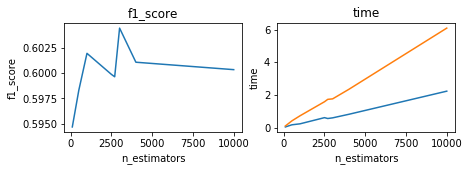

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 2]
figs, axs = plt.subplots(1, 2)
axs[0].plot(n_estimators_a, f1_score)

axs[0].set_title("f1_score")
axs[0].set_xlabel("n_estimators")
axs[0].set_ylabel("f1_score")

axs[1].set_title("time")
axs[1].set_xlabel("n_estimators")
axs[1].set_ylabel("time")

axs[1].plot(n_estimators_a, eval_time_sum)
axs[1].plot(n_estimators_a, train_time_sum)
plt.show()

Итого максимум качества, которого удалось добиться с помощью композиции деревьев 0.6044043605286705 с ```n_estimator```=3000, достигнута методом бэггинга. Все остальные модели показали себя хуже, чем версии без композиций.